In [1]:
import numpy as np
import pandas as pd
from data import Stock
import matplotlib.cm as cm
from analysis import Analysis
import matplotlib.pyplot as plt
from hidden_markov_model import Hidden_Markov_Model

In [2]:
sa40 = Stock('JTOPI', pd.read_csv('2015_2025_Historical_Data.csv'))

In [3]:
sa40.series_data

,Date,Price,Open,High,Low,Vol.,Return,Log_Return
1,2015-01-05,41990.24,43696.74,43882.81,41990.24,81.67,-0.039053,-0.039836
2,2015-01-06,42747.37,41990.24,42747.37,41983.39,78.48,0.018031,0.017870
3,2015-01-07,43086.35,42747.37,43159.91,42376.08,63.80,0.007930,0.007899
4,2015-01-08,43670.79,43086.35,43670.79,43020.22,76.25,0.013564,0.013473
5,2015-01-09,42994.58,43670.79,43785.33,42994.58,100.66,-0.015484,-0.015605
...,...,...,...,...,...,...,...,...
2494,2024-12-23,76067.93,75888.86,76277.36,75490.51,69.16,0.002360,0.002357
2495,2024-12-24,76320.99,76067.93,76588.19,75940.86,20.99,0.003327,0.003321
2496,2024-12-27,76197.46,76320.99,76603.50,75871.35,67.81,-0.001619,-0.001620
2497,2024-12-30,75427.05,76197.46,76221.20,75249.61,70.26,-0.010111,-0.010162


In [4]:
model = Hidden_Markov_Model(sa40.series_data['Log_Return'].to_numpy(), 2)
model.baum_welch_algorithm(0.00001, 100)

Iteration 1 . . . Log-Likelihood = 7408.057563193552
Iteration 2 . . . Log-Likelihood = 7409.25259284417
Iteration 3 . . . Log-Likelihood = 7419.851970645178
Iteration 4 . . . Log-Likelihood = 7445.463195210603
Iteration 5 . . . Log-Likelihood = 7478.797213470684
Iteration 6 . . . Log-Likelihood = 7510.7938659670335
Iteration 7 . . . Log-Likelihood = 7535.2280264972
Iteration 8 . . . Log-Likelihood = 7550.856269902217
Iteration 9 . . . Log-Likelihood = 7560.31184251696
Iteration 10 . . . Log-Likelihood = 7566.763822352076
Iteration 11 . . . Log-Likelihood = 7572.072830610545
Iteration 12 . . . Log-Likelihood = 7576.97859293963
Iteration 13 . . . Log-Likelihood = 7581.702012170475
Iteration 14 . . . Log-Likelihood = 7586.284339816864
Iteration 15 . . . Log-Likelihood = 7590.7134839305145
Iteration 16 . . . Log-Likelihood = 7594.9634324531835
Iteration 17 . . . Log-Likelihood = 7599.006575471888
Iteration 18 . . . Log-Likelihood = 7602.818444542387
Iteration 19 . . . Log-Likelihood = 760

In [5]:
model.get_parameters()

==================================== 0 =====================================
Initial Probability: 1.0
Mean: -0.0002813807873018405
Variance: 0.0003934294439108304


==================================== 1 =====================================
Initial Probability: 6.1873825581786796e-288
Mean: 0.00037626374586764293
Variance: 7.779093496691627e-05


Transition Matrix: [[0.92904621 0.07095379]
 [0.01780069 0.98219931]]
Log Likelihood: 7631.395097589679


In [6]:
analysis = Analysis()

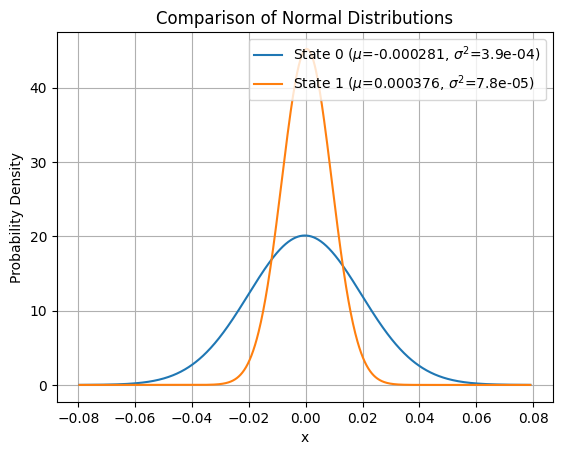

In [7]:
mean_array, variance_array = model.get_mean_variance()
analysis.plot_distributions(mean_array, variance_array)

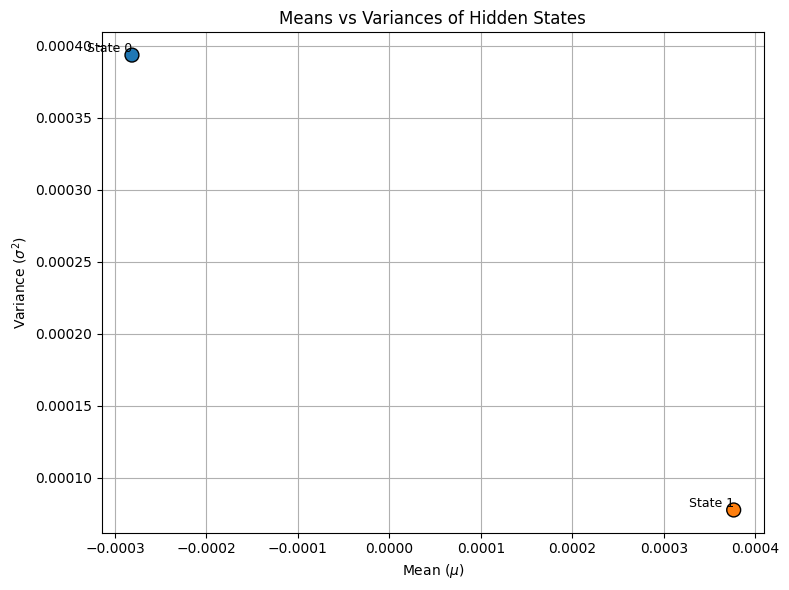

In [8]:
analysis.mean_variance_plot(mean_array, variance_array)

In [9]:
state_sequence = model.viterbi_algorithm()

In [10]:
state_sequence

array([0, 0, 0, ..., 1, 1, 1])

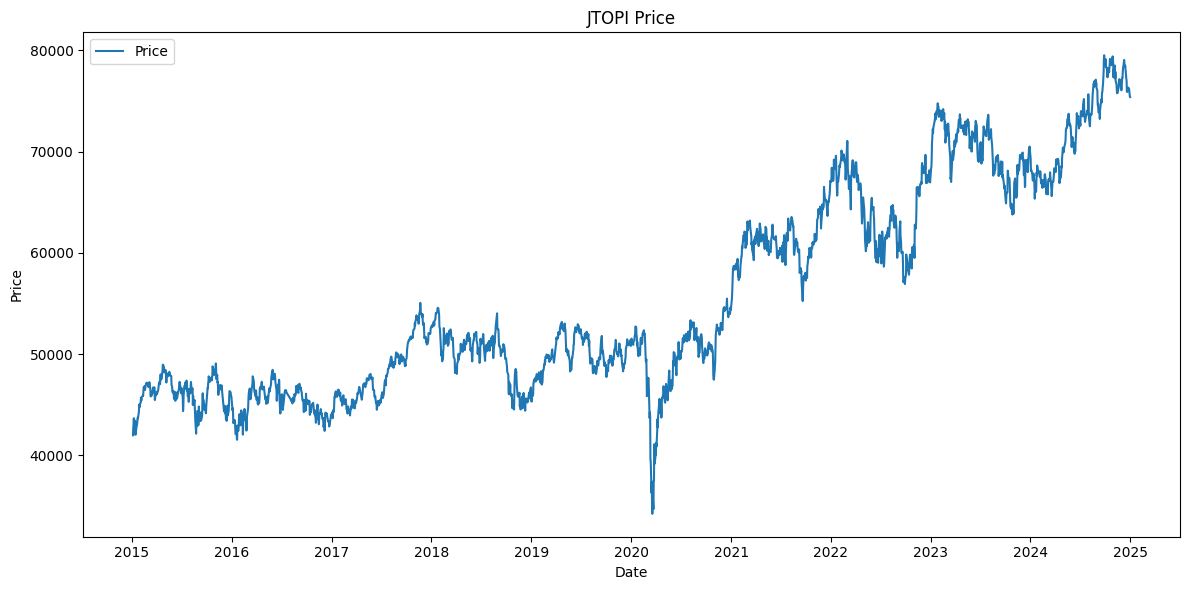

In [13]:
analysis.price_plot(sa40, 'Price')

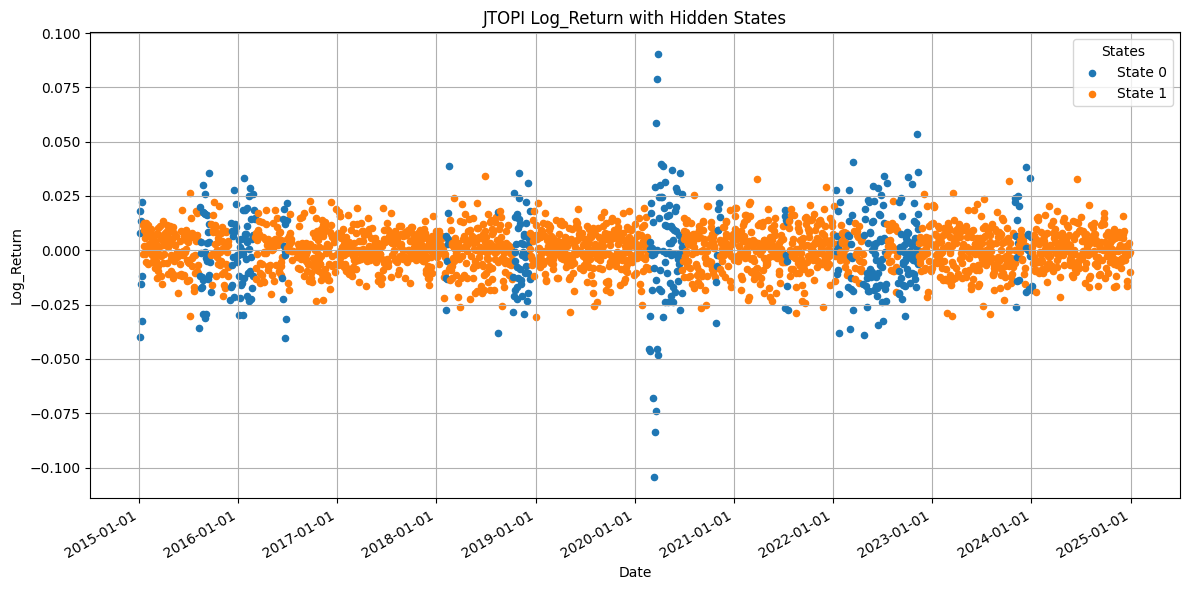

In [11]:
analysis.states_plot_points(sa40, 'Log_Return', state_sequence)

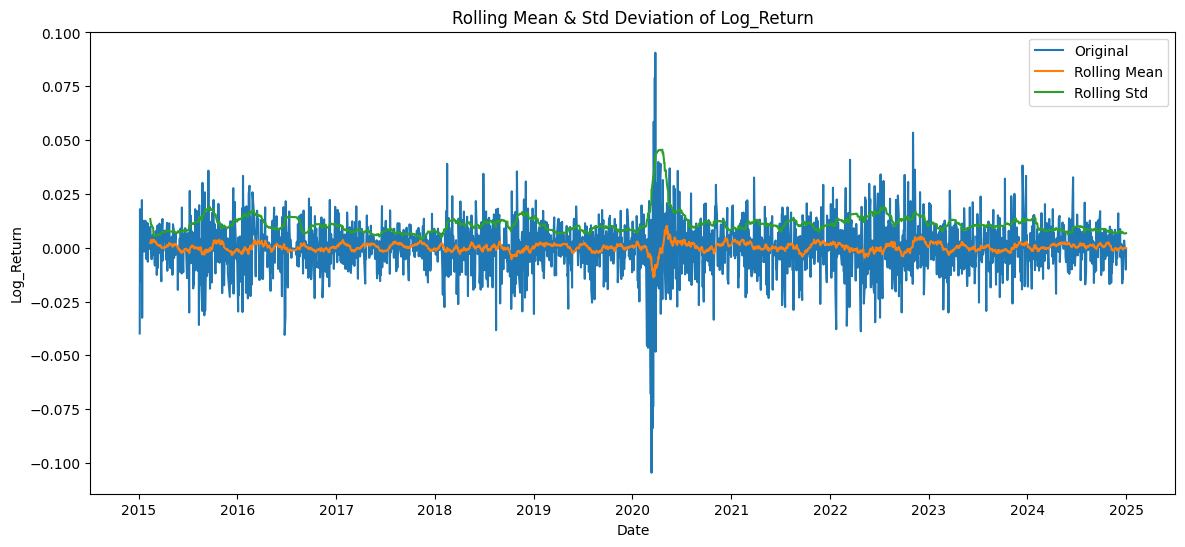

In [14]:
analysis.rolling_plot(sa40, 'Log_Return')

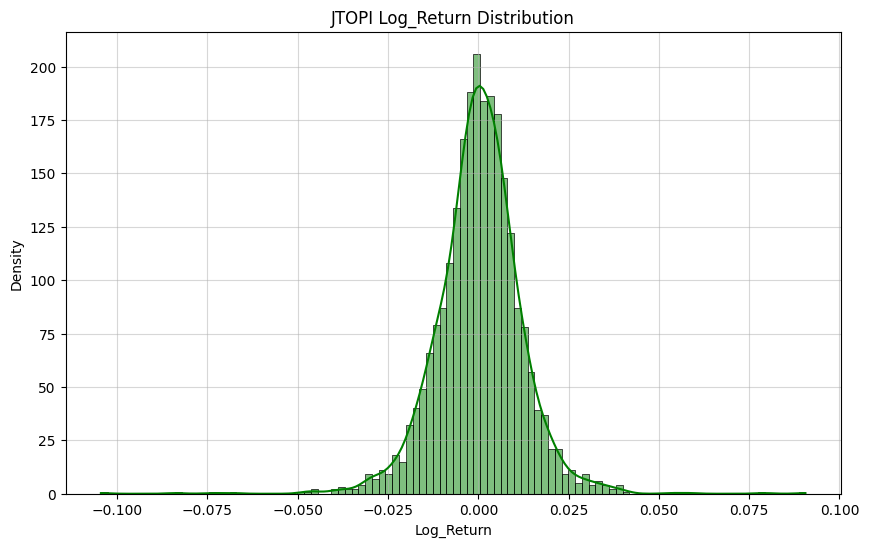

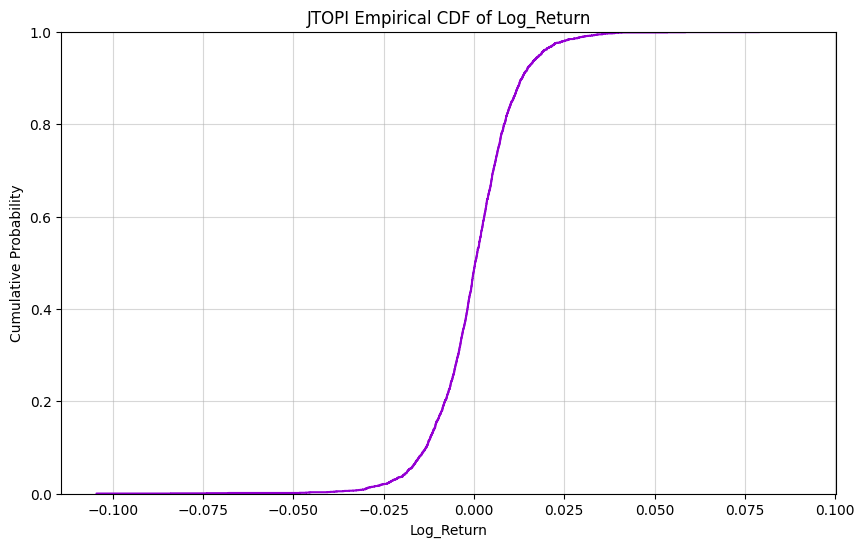

In [17]:
analysis.distribution(sa40, 'Log_Return')